# Regress the quality of a wine like a boss
## Write your own DNN in python

Copyright (c) Pietro Vischia, 2020

A [study by Cortez et al.](http://dx.doi.org/10.1016/j.dss.2009.05.016) has attempted to estimate the quality of a wine as a function of its physical and chemical qualities.

If you can't access it, then [you may consider using someone's institution proxy (click on the link. You may have to use TOR for that)](https://sci-hub.se/https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377?via%3Dihub)

Some human expert winetasters have tried out some Portugues red and white wines, and have classified them by quality from 0 to 10.

The wines have also been studied by measuring eleven of their their physicochemical qualities, namely:
    - fixed acidity
    - volatile acidity
    - citric acid
    - residual sugar
    - chlorides
    - free sulfur dioxide
    - total sulfur dioxide
    - density
    - pH
    - sulphates
    - alcohol
    
A database of the data used for the study is available [in the UCI Machine Learning Datasets Database](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

We will try to learn the function that describes the perceived wine quality as a function of the physiochemical qualities.
The idea is that if we can make such a prediction, then winemakers can produce and commercialize wines by estimating in advance whether they will be well-accepted by the market.

Here I should go on a long rant about whether quality assessed by human winetasters is actually meaningful.
Basically, as far as I can gather, blind tests have shown that winetasting [may actually be decorated BS](https://en.wikipedia.org/wiki/Blind_wine_tasting).

Since our target variable is not necessarily reflecting the real quality of the wine, it is not clear of what the network is learning, so it may very well be that the network does not fare much better than randomly assigning a wine quality.

We will start by downloading the datasets: you need to run the next cell only once (or you will download multiple copies of the same file)

There are two databases: a database of Portuguese red wines, and one of vinhos verdes (green wines). Vinho verde is a sweet and delicious type of white wine from Portugal.

---

We will train a neural network on the red wines. We will then apply it to the white wines, expecting that it should have a worse performance (since it has been trained on the chemical quantities of red wines)


In [1]:
import wget
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Let's first get the necessary files

In [2]:


files=['https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
]
    
for f in files:
    if not os.path.exists('./%s'%os.path.basename(f)): # so that we can rerun this without worrying of duplicate downloads
        wget.download(f, './%s'%os.path.basename(f))



Load the data into a numpy array. For now we load only the red wines (on which we will train the network).

In [3]:
data = pd.read_csv('winequality-red.csv', delimiter=';')

    
# Visualize the first five entries
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Usually at this point you have to split your dataset into:

- a training dataset: the network will be trained on it;
- a test dataset: the network's hyperparameters will be optimized using this dataset;
- a validation dataset: the performance of your optimized network is validated in this independent dataset for future reference.

Often in HEP people use the validation dataset also as the test dataset. You can do this typically if you don't perform many optimizations of the network, if you don't expect overtraining (the set would be used to assess when to stop training), and if you have enough events that statistical fluctuations are negligible. However,  using the same dataset for testing and validation involves a risk of introducing biases.

Some authors switch the names _test_ and _validation_.

For simplicity, today we will split only into a training dataset and a test dataset to evaluate the performance of our network.

We start by randomly shuffling the rows of the dataset, to make sure we break whatever order might have been used when building the file. We perform the shuffle by sampling randomly without replacement all events of the sample. Finally, we split into two the resulting set of events, and we separate the predictors (physiochemical quantities) and target (sensorial quality) variables.

Let's do a 50/50 split, although it's often more common to use as much as 80% events for training and only 20% for testing.

If you had to actualy shuffle as if it was a deck of cards, please take note of the works by Persi Diaconis, who has estimated that for example if you want to achieve a really random ordering when shuffling by hand a 52 cards deck, you should shuffle about 7 times.

In [4]:
data = data.sample(frac=1).reset_index(drop=True)

data_tr=data.head(int(len(data)/2))
data_te=data.tail(len(data)-int(len(data)/2))

print('Sanity check: ', len(data), '==', len(data_tr), '+', len(data_te),': ', len(data)==len(data_tr)+len(data_te))


Sanity check:  1599 == 799 + 800 :  True


Now we need to separate our predictors from the target variable

In [5]:
y_train = np.array(data_tr['quality'])
x_train = data_tr.drop(['quality'], axis=1).T
y_test  = np.array(data_te['quality'])
x_test  = data_te.drop(['quality'], axis=1).T



Now that we have our dataset ready, it's time to...

## Code a neural network from scratch

#### Details on neural networks

Biology teaches us that the brain is constituted of neurons and connections between them: the synapses.
By comparing the brain of various animals, we now think that the more the number of neurons and most importantly of synapses is large, the more complex are the functions that the brain can execute.

Let's learn the inner workings of a very simplified mathematical model of brain: an artificual neural network.

The first element is the neuron. The simplest model (and one of the first) we have is the [*perceptron*](https://en.wikipedia.org/wiki/Perceptron). The neuron is modelled by a mathematical function that takes some arguments as inputs, combines them linearly, and returns an output value.
We denote as *weights* the coefficients of the linear combination.

However, we want to be able to approximate nonlinear functions, so we need to plug in a degree of nonlinearity inside the neuron, and we want the neuron to fire only when a certain threshold in the output is reached (a certain amount of stimulation).

We modify the output of the neuron by an activation function $f_{act}$: the neuron is activated if the activation function returns a non-zero value. The output of the neuron is defined as:

$$
y_n = f_{act}(\sum_i w_{i,n} x_{i,n})
$$

If the activation function is not linear, we are happy because we have obtained a neuron that gives a nonlinear output and gets activated only if the stimuli it receives are large enough.

You will use in this exercise two activation functions:

- [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), a function $f(x)$ that returns 0 if $x<0$, and $x$ otherwise;
- [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), a function that rescales any number into a number between 0 and 1.

Here you have a graphical representation of the perceptron, by [https://towardsdatascience.com](https://towardsdatascience.com):

![neuron](https://miro.medium.com/max/1435/1*n6sJ4yZQzwKL9wnF5wnVNg.png "Figure from https://towardsdatascience.com")

Now we have to connectthe neurons. The simplest way is to build layers of neurons, and to connect all neurons of consecutive layers. Starting with the inputs, there is a first layer of neurons. Each neuron combines linearly the inputs and passes the result through activation function to give an output value. The set of outputs of a layer will be the input of the following layer:

![neuralnet](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/800px-Colored_neural_network.svg.png "Figure from wikipedia")

A neural network is characterized by a set of weights assigned to the connections that define the structure of the network. You can see this as a mathematical function with many free parameters (the weights) that takes the inputs and gives an output. The problem of learning is then the problem of finding the values of the free parameters that minimize the difference between the output and the target distribution that we want to learn.


#### The training process

Schematically, the training process consists in:

- for each epoch
   * for each training set data point:
      1. calculate the output of each neuron, starting from the inputs to the output
      2. compare the output of the last neuron with the reference wine quality
      3. propagate the error back towards the inputs, without updating the weights (the error needs to be propagated with respect to the current values of the weights)
      4. update all the weights
      5. save the value of the loss function for each event
   * for each test set data point:
      1. save the value of the loss function for each event
   * aggregate the errors by computing a Mean Squared Average (MSE)
      1. the MSE of the errors in the training dataset events is the average training loss
      2. the MSE of the errors in the test dataset is the averate validation loss (you see here I am using validation and test indifferently)

The idea is the training will stop when the loss function doesn't improve anymore (it remains stationary at its minimum. If the training loss keeps diminishing and the test loss begins increasing, then we might be starting to learn statistical fluctuations of the training dataset.


#### Clarification on the connections between networks (to fix ideas)

If the network has the following structure: (input layer: two inputs `A` et `B`;  first internal (_hidden_) layer: two neurons `1a` et `1b`; second hidden layer: two neurons `2a` et `2b`; output `y`), the list of connections (the weights) is:

- Four weights connecting the inputs to the layer 1:
    - `wA1a` (connects input `A` to neuron `1a`)
    - `wA1b` (connects input `A` to neuron `1b`)
    - `wB1a` (connects input `B` to neuron `1a`)
    - `wB1b` (connects input `B` to neuron `1b`)
- Four weights connecting the neurons of layer 1 to those of layer 2:_
    - `W1a2a` (connects neuron `1a` to neuron `2a`)
    - `W1a2b` (connects neuron `1a` to neuron `2b`)
    - `W1b2a` (connects neuron `1b` to neuron `2a`)
    - `W1b2b` (connects neuron `1b` to neuron `2b`)
- Two weights connecting the neurons of layer 2 to the output y:
    - `W2ay` (connects neuron `2a` to output `y`)
    - `W2by` (connects neuron `2b` to output `y`)

####  Backpropagation

To perform backpropagation we need, for each neuron, to propagate back the error of the neurons of the following layer (so you need to go backwards). We use the chain rule.

- Error for a neuron of the output layer:

$$
\epsilon = (y_{true} - \hat{y}) * activation\_derivative(\hat{y})
$$

Here $\hat{y}$ is the output of this output neuron, and $y_{true}$ is the target quality of the wine

- Error for a neuron $m$ of an internal layer $N$:

$$
\epsilon_{m, N} = \sum_{k} (w_{k, N+1} * \epsilon_{k, N+1}) * activation\_derivative(\hat{m})
$$

Here, $\epsilon_{k,N+1}$ is the error of the neuron $k$ of the following layer (layer $N+1$), $w_{k, N+1}$ is the weight of the connection between the neuron $m$ and the neuron $k$ of the next layer, and $\hat{m}$ is the output of neuron $m$


#### Updating the weights

After having backpropagated all the gradient, you have to update all the weights using this formula:

$$
w = w + learning\_rate * erreur * input
$$

Ici $erreur$ is the error calculated via backpropagation, $input$ is the input value of the neuron that had been originally passed to the neuron, and $learning rate$ is a parameter governing how fast we climb down the gradient.

 
#### At the end of each epoch

To check for convergence of the network, a standard practice is to aggregeate the errors $\hat{y} - y_{true}$  of all the events at the end of each epoch, in order to reduce the sensitivity to statistical fluctuations in the training sample. The first pillar of statistical wisdom according to Stigler is precisely aggregation. 

In analogy with $\chi^2$ fit, we can for example calculate the $MSE = \frac{1}{N} \sum_{events} (\hat{y}-y_{true})^2$ and plot the MSE as a function of the number of epochs. If the network is improving its predictions, we should see something like this:

![mse](https://cern.ch/vischia/mse_pythonCourse.png "Figure by Pietro Vischia, 2019")

#### Diagnostic plots

- 1) MSE as a function of the epoch
- 2) Histogram of $\frac{\hat{y} - y_{true}}{y_{true}}$ 
- 3) Histogram of $\frac{\hat{y} - y_{true}}{y_{true}}$ as a function of $y_{true}$


### Weights initialization
- To initialize the weights at the beginning you can use a Gaussian, or a truncated gaussian ( (scipy.stats.truncnorm), or a $random uniform[0,1]$


---

Let's now start with the elements we need.

First, we need to realize that although we could in principle model the problem in an object-oriented way, that is define a class `Neuron` and have a class `Network` that collects neurons maybe into instances of a class `Layer`, this doesn't exploit the synthetical concepts behind representing neural network operations in a backgpropagation-friendly way.

In other words, the simplest way we can encode the problem is to have in our mind the neural structure as a set of neurons with connections, and write instead in the code the problem as a set of weights that must be combined in ways defined by the neurons.

This highlights the fact that the neuron outputs are transient: the real parameters of the network, that we must store for learning and later use, are the weights.

All of this to say that we will just store appropriately-sized matrices of weights, and the neurons wil "exist" as operations of matrix multiplication between the weights matrices.

To make matrix multiplication we will use `np.dot`

In [6]:
# a: 2x3
a=[
    [2,2,3],
    [2,2,3]
]
# b: 3x4
b=[
   [1,2,3,4],
   [1,2,3,4],
   [1,2,3,4]
]

# a dot b: 2x4

print(np.dot(a,b))

[[ 7 14 21 28]
 [ 7 14 21 28]]


Next we need to write our activation function and its derivative.

Let's implement the sigmoid (we will use it for the output layer).
You can also implement the ReLU if you wish.


In [7]:
def sigmoid(input):    
    return 1. / (1. + np.exp(-input))

# Define the sigmoid derivative function
def sigmoid_derivative(input):
    return sigmoid(input) * (1.0 - sigmoid(input))

Let's plot both

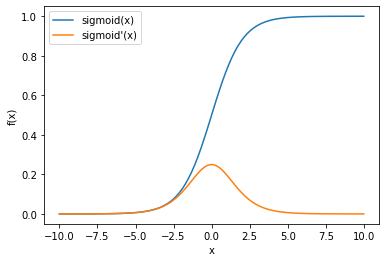

In [8]:
x=np.linspace(-10,10,100)

plt.plot(x, sigmoid(x), label='sigmoid(x)')
plt.plot(x, sigmoid_derivative(x), label='sigmoid\'(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc='best')

The activation function become larger than 0.5 at $x=0$. We need to include the possibility of shifting the value for which the neuron activates. This is done by introducing a bias.

The neuron output from

$$
y = f(\sum(w_i x_i))
$$

(that activates for $\sum(w_i x_i)>0$) will be

$$
y = f(\sum(w_i x_i+ w_bb) )
$$

that activates at a learnable ($w_b$) value. 


Now we need to define what's the structure of the network.

Let's assume we have one input layer,  one hidden layer, and one output layer. We now define the number of neurons per each layer. You can generalize to an array of hidden layers.

In [9]:
n_inputs = x_train.shape[0]
n_hidden = 20  
n_output = 1


We now have to create the arrays for the weights and initialize the weights to a starting value, for the first forward pass. The weights will be later updated.

Remember to set appropriate sizes to account for the dot products.

You can later try to see what changes in the training when initializing e.g. with gaussian weights.

Let's also disregard the bias :D

In [25]:
# From input layer to hidden layer
weights_input_hidden = np.random.uniform(size=(n_inputs, n_hidden))
# From hidden layer to output layer
weights_hidden_output = np.random.uniform(size=(n_hidden, n_output))

Now we need to implement the forward pass, for each layer transition.

We can also print out what happens for an untrained forward pass, and the MSE

In [29]:
# calculating hidden layer activations
hiddenLayer_linearTransform = np.dot(weights_input_hidden.T, x_train)
hiddenLayer_activations = sigmoid(hiddenLayer_linearTransform)

# calculating the output
outputLayer_linearTransform = np.dot(weights_hidden_output.T, hiddenLayer_activations)
output = sigmoid(outputLayer_linearTransform)



print('MSE:', np.sum(np.square(y_train - output))/len(y_train))


MSE: 21.850894689741345


Now we need to implement the backpropagation algorithm. We start with the rate of change of the output error

In [30]:
error = np.square(y_train - output) / 2


Now, let's proceed through the layers

In [31]:


# calculating rate of change of error w.r.t weight between hidden and output layer
error_wrt_output = -(y_train - output)
output_wrt_outputLayer_LinearTransform = np.multiply(output, (1 - output))
outputLayer_LinearTransform_wrt_weights_hidden_output = hiddenLayer_activations

error_wrt_weights_hidden_output = np.dot(
            outputLayer_LinearTransform_wrt_weights_hidden_output,
        (error_wrt_output * output_wrt_outputLayer_LinearTransform).T,
        )

# calculating rate of change of error w.r.t weights between input and hidden layer
outputLayer_LinearTransform_wrt_hiddenLayer_activations = weights_hidden_output
hiddenLayer_activations_wrt_hiddenLayer_linearTransform = np.multiply(
            hiddenLayer_activations, (1 - hiddenLayer_activations)
    )
hiddenLayer_linearTransform_wrt_weights_input_hidden = x_train
error_wrt_weights_input_hidden = np.dot(
        hiddenLayer_linearTransform_wrt_weights_input_hidden,
        (
            hiddenLayer_activations_wrt_hiddenLayer_linearTransform
            * np.dot(
                outputLayer_LinearTransform_wrt_hiddenLayer_activations,
                (output_wrt_outputLayer_LinearTransform * error_wrt_output),
            )
        ).T,
    )

In [32]:
lr=0.1
epochs=1000

In [33]:
# updating the weights
weights_hidden_output = weights_hidden_output - lr * error_wrt_weights_hidden_output
weights_input_hidden = weights_input_hidden - lr * error_wrt_weights_input_hidden



Now we have described fully the process.

Let's put it together in a loop!

In [34]:
losses = []
lr=0.1
epochs=100

for epoch in range(epochs):
    ## Forward Propogation

    # calculating hidden layer activations
    hiddenLayer_linearTransform = np.dot(weights_input_hidden.T, x_train)
    hiddenLayer_activations = sigmoid(hiddenLayer_linearTransform)

    # calculating the output
    outputLayer_linearTransform = np.dot(
        weights_hidden_output.T, hiddenLayer_activations
    )
    output = sigmoid(outputLayer_linearTransform)

    ## Backward Propagation

    # calculating error
    error_blah = np.square(y_train - output) / 2

    # calculating rate of change of error w.r.t weight between hidden and output layer
    error_wrt_output = -(y_train - output)
    output_wrt_outputLayer_LinearTransform = np.multiply(output, (1 - output))
    outputLayer_LinearTransform_wrt_weights_hidden_output = hiddenLayer_activations

    error_wrt_weights_hidden_output = np.dot(
        outputLayer_LinearTransform_wrt_weights_hidden_output,
        (error_wrt_output * output_wrt_outputLayer_LinearTransform).T,
    )

    # calculating rate of change of error w.r.t weights between input and hidden layer
    outputLayer_LinearTransform_wrt_hiddenLayer_activations = weights_hidden_output
    hiddenLayer_activations_wrt_hiddenLayer_linearTransform = np.multiply(
        hiddenLayer_activations, (1 - hiddenLayer_activations)
    )
    hiddenLayer_linearTransform_wrt_weights_input_hidden = x_train
    error_wrt_weights_input_hidden = np.dot(
        hiddenLayer_linearTransform_wrt_weights_input_hidden,
        (
            hiddenLayer_activations_wrt_hiddenLayer_linearTransform
            * np.dot(
                outputLayer_LinearTransform_wrt_hiddenLayer_activations,
                (output_wrt_outputLayer_LinearTransform * error_wrt_output),
            )
        ).T,
    )

    # updating the weights
    weights_hidden_output = weights_hidden_output - lr * error_wrt_weights_hidden_output
    weights_input_hidden = weights_input_hidden - lr * error_wrt_weights_input_hidden

    # print error at every 100th epoch
    epoch_loss = np.average(error_blah)
    if epoch%100==0:
        print(f"Error at epoch {epoch} is {epoch_loss}")

    # appending the error of each epoch
    losses.append(epoch_loss)

Error at epoch 0 is 10.925134077978809


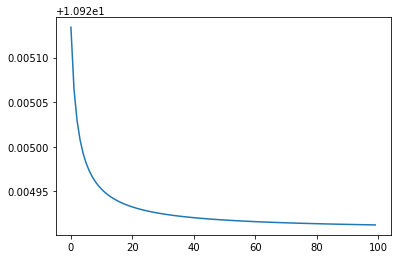

In [35]:
plt.plot(losses)

In [36]:
print(losses)

[10.925134077978809, 10.925064493899416, 10.925029089344932, 10.925007156477973, 10.924992096466292, 10.92498106313148, 10.924972607607147, 10.924965908458072, 10.924960462918698, 10.924955945031623, 10.924952133733687, 10.924948873560941, 10.924946051863651, 10.92494358494067, 10.924941409255922, 10.92493947568213, 10.924937745617038, 10.92493618829594, 10.924934778890453, 10.92493349713689, 10.924932326329332, 10.92493125256877, 10.924930264195266, 10.924929351352976, 10.924928505653078, 10.924927719909713, 10.924926987931169, 10.924926304353177, 10.924925664504746, 10.92492506429938, 10.924924500146137, 10.924923968876552, 10.924923467684092, 10.924922994073809, 10.92492254582013, 10.924922120931392, 10.924921717619808, 10.924921334275991, 10.924920969447177, 10.924920621818583, 10.924920290197376, 10.924919973498822, 10.924919670734294, 10.924919381000818, 10.924919103471998, 10.924918837390031, 10.924918582058739, 10.924918336837404, 10.924918101135349, 10.924917874407138, 10.9249